In [3]:
from regressor_models import (
    DumbRegressor,
    LinearRegressor,
    RFRegressor,
)

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import shap

c:\Users\bella\Documents\GitHub\CountryHappinessPredictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_parquet("./eda/dataset_complete.parquet")

Evaluation

In [5]:
train = df[df["year"] < 2019]
test  = df[df["year"] == 2019]

y_train = train["score"]
y_test  = test["score"]

# Drop non-features
drop_cols = ["country", "year", "score"]
X_train = train.drop(columns=drop_cols)
X_test  = test.drop(columns=drop_cols)

In [6]:
def evaluate_regressor(model, X_train, y_train, X_test, y_test, name="Model"):
    print(f"\n======= Evaluating {name} =======")
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [8]:
models = {
    #"Linear Regression": LinearRegressor(),
    "Dumb Regressor": DumbRegressor(),
    "Random Forest": RFRegressor(),
}

results = {}

for name, model in models.items():
    results[name] = evaluate_regressor(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        name=name
    )



======= Evaluating Dumb Regressor =======
MAE : 0.6752
RMSE: 0.8466
R²  : 0.4461

======= Evaluating Random Forest =======
MAE : 0.2219
RMSE: 0.2939
R²  : 0.9333


Visualizations

SHAP Beeswarm Plot

In [9]:
rf_model = models["Random Forest"].model

c:\Users\bella\Documents\GitHub\CountryHappinessPredictor\.venv\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


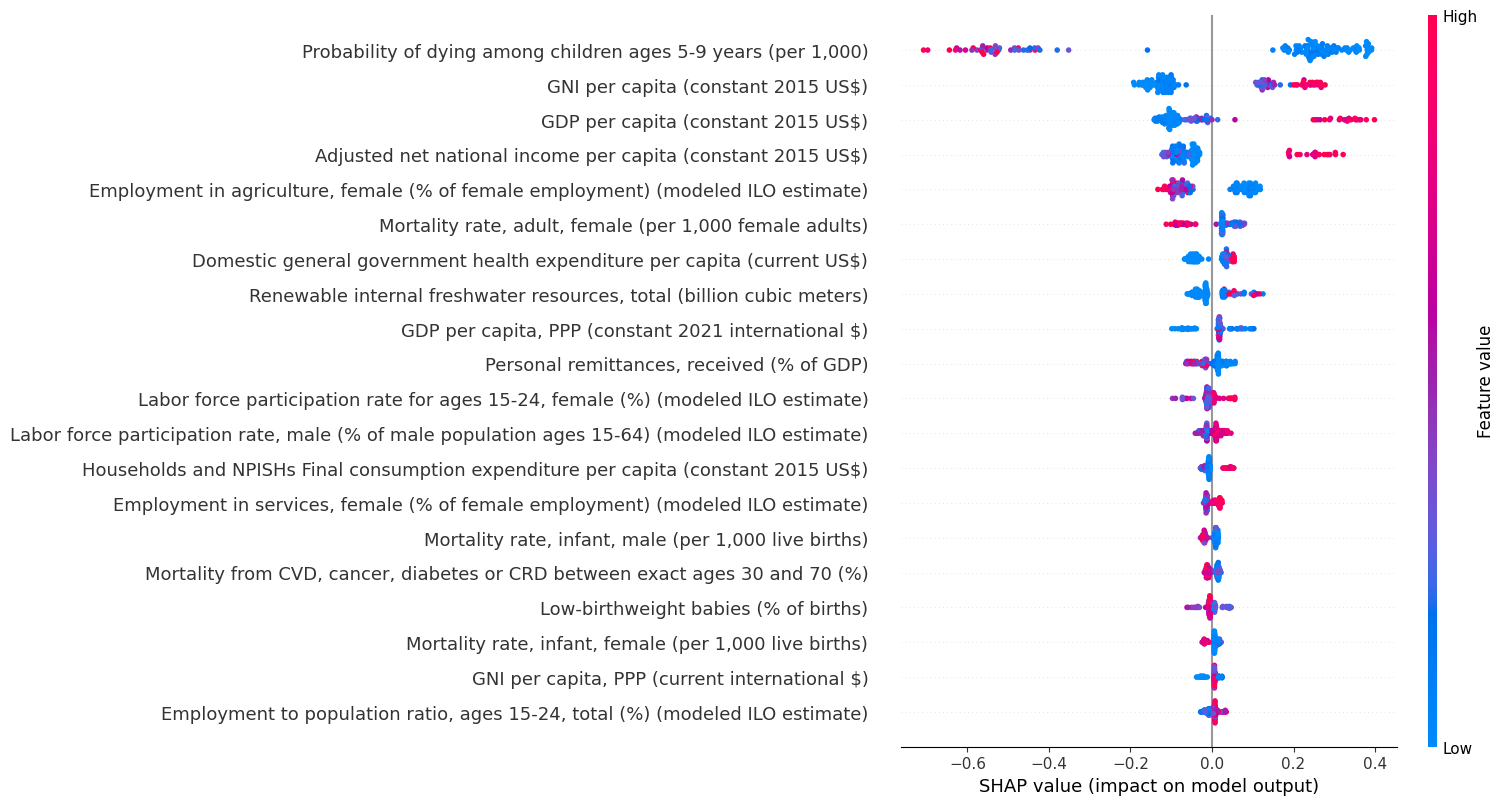

In [11]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=20)

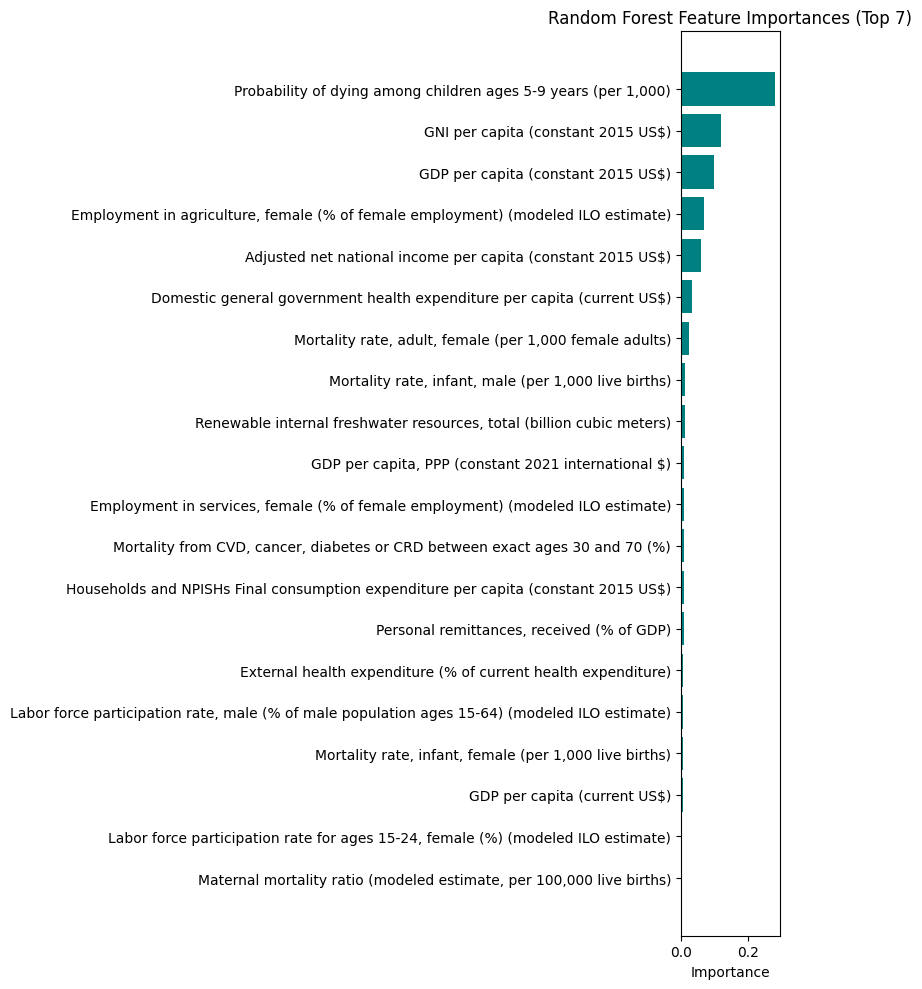

In [ ]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort top N
N = 20
idx = np.argsort(importances)[-N:]
top_features = feature_names[idx]
top_importances = importances[idx]

plt.figure(figsize=(8, 10))
plt.barh(top_features, top_importances, color="teal")
plt.title("Random Forest Feature Importances (Top 7)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

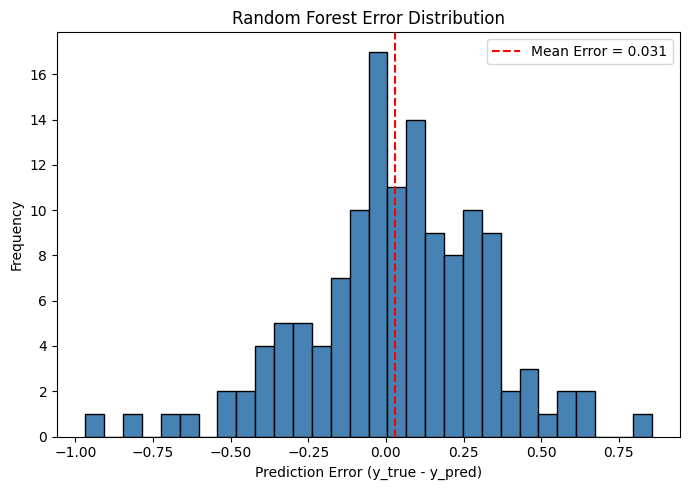

In [43]:
preds = rf_model.predict(X_test)

errors = y_test - preds
plt.figure(figsize=(7,5))
plt.hist(errors, bins=30, color="steelblue", edgecolor="black")
plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean Error = {errors.mean():.3f}")
plt.title("Random Forest Error Distribution")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

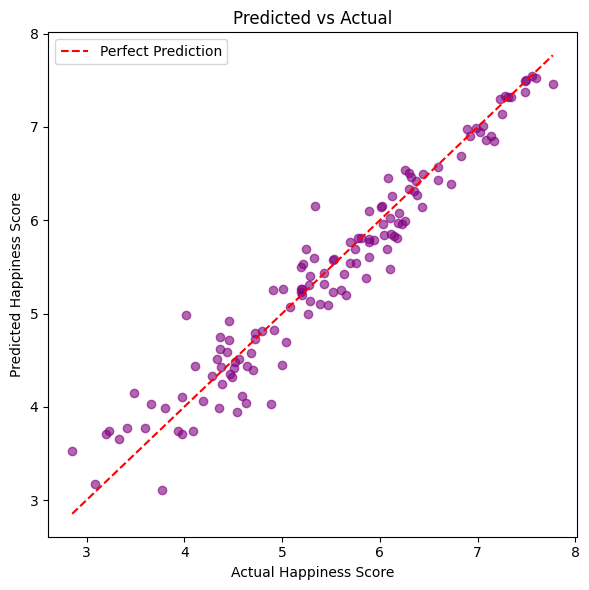

In [44]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            "r--", label="Perfect Prediction")
plt.xlabel("Actual Happiness Score")
plt.ylabel("Predicted Happiness Score")
plt.legend()
plt.title("Predicted vs Actual")
plt.tight_layout()
plt.show()

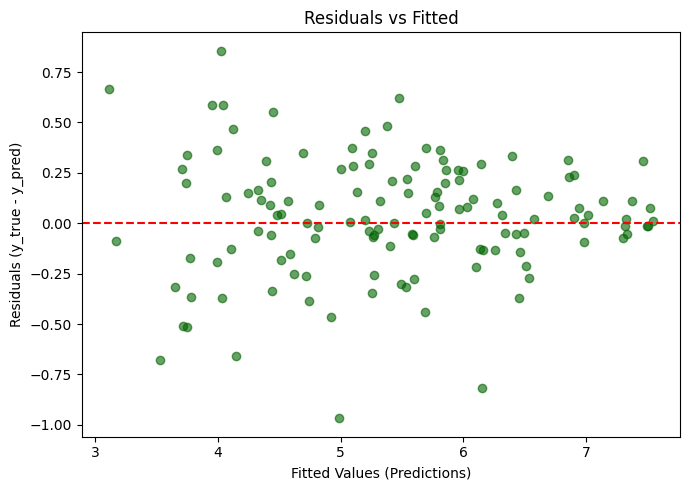

In [45]:
residuals = y_test - preds

plt.figure(figsize=(7,5))
plt.scatter(preds, residuals, alpha=0.6, color="darkgreen")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Predictions)")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Fitted")
plt.tight_layout()
plt.show()